# Modelos de Clasificación.

En este documento desarrollaremos algunos modelos de clasificación.

Primero comenzamos importando las librerías necesarias.

In [13]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score,
    precision_recall_curve
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#### Preparación de Datos

Importamos nuestros datos.

In [14]:
# Cargamos los datos.
car_data = pd.read_csv('../data/car_data_clean.csv', sep=',')

# Mostramos la forma y los primeros registros de nuestro DataFrame.
print(car_data.shape)
car_data.head()

(58049, 22)


,PRODUCTO,TIPO_CARROCERIA,COMBUSTIBLE,Potencia_,TRANS,FORMA_PAGO,ESTADO_CIVIL,GENERO,OcupaciOn,PROVINCIA,...,Campanna3,Zona _Renta,REV_Garantia,Averia_grave,QUEJA_CAC,COSTE_VENTA,km_anno,Mas_1_coche,Revisiones,Edad Cliente
0,0,0,0,1,1,0,0,1,1,4,...,0,2,0,2,1,2,0,0,2,0
1,0,0,0,1,1,0,0,0,1,47,...,0,2,1,3,0,0,0,0,2,2
2,0,0,0,1,1,3,0,1,1,30,...,0,1,0,3,0,0,0,1,4,0
3,0,0,0,1,1,2,0,0,1,32,...,0,1,1,2,1,2,0,1,4,1
4,0,0,0,1,1,2,0,0,2,41,...,1,0,0,3,0,0,0,1,3,0


Definimos nuestra variable objetivo para nuesgtra predicción, que consiste en atraer más clientes.

In [15]:
# Definimos las variables predictoras y la variable objetivo.
X = car_data.drop(labels=['Mas_1_coche'], axis=1)
y = car_data['Mas_1_coche']

El próximo paso es estandarizar los datos para que todos queden en la escala 0 a 1.

In [16]:
# Creamos un objeto StandardScaler.
scaler = StandardScaler()

# 1º Filtramos las columnas que tengan valores mayores a 1.
cols = [col for col in X.columns if X[col].max() > 1]

# 2º Ajustamos y escalamos las columnas especificadas.
for col in cols:
    X[col] = scaler.fit_transform(X[[col]])  # Escalamos cada columna de manera individual.

Una vez los datos preparados, separamos en train y test.

In [17]:
# Dividimos los datos en entrenamiento y test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#### Entrenamiento de modelos

Ahora desarrollamos y entrenamos nuestros modelos. En nuestro caso, hemos trabajado con Random Fores, Grandient Boost y XGBoost.

In [18]:
class Model:
    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test

    def train_random_forest(self):
        pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                                   ('regressor', RandomForestClassifier(n_estimators=100, random_state=42))])
        random_forest_model = pipeline.fit(self.x_train, self.y_train)
        return random_forest_model

    def train_gradient_boosting(self):
        pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                                   ('regressor', GradientBoostingClassifier(random_state=912))])
        gradient_boosting_model = pipeline.fit(self.x_train, self.y_train)
        return gradient_boosting_model

    def train_XGB(self):
        pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                                   ('regressor', XGBClassifier(random_state=912))])
        gradient_boosting_model = pipeline.fit(self.x_train, self.y_train)
        return gradient_boosting_model

model = Model(X_train, X_test, y_train, y_test)

GB_model = model.train_gradient_boosting()
RF_model = model.train_random_forest()
XGBClassifier_model = model.train_XGB()

In [19]:
print(XGBClassifier_model)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=Non

#### Evaluación

Una vez entrenado el modelo, lo evaluamos. Comenzamos con una validación cruzada sobre la miestra `train` que posteriormente compararemos con el accuracy del modelo.

In [20]:
# Función que realiza validación cruzada.

def cross_eval(model, x_train, y_train):
    return cross_val_score(model, x_train, y_train, cv=5)

# Aplicamos la función que hemos creado para realizar una validación cruzada.
result_RF = cross_eval(RF_model, X_train, y_train)
result_GB = cross_eval(GB_model, X_train, y_train)
result_XGB = cross_eval(XGBClassifier_model, X_train, y_train)

El próximo paso de la evaluación es obtener la exactitud, la sensibilidad, la precisión, el F1 score y el AUC (Área Bajo Curva). Además graficamos algunos diagramas para facilitar la comprensión de los resultados obtenidos.

In [21]:
# Evaluación de todos los modelos escalados, ya que tienen mejor rendimiento.

modelos = {
    'Random Forest': RF_model,
    'Gradient Boosting': GB_model,
    'XGBoost': XGBClassifier_model
}

# Crear un diccionario para almacenar las métricas de cada modelo.
metricas = {}

# Iterar sobre cada modelo.
for nombre, modelo in modelos.items():
    # Realizar predicciones en el conjunto de prueba.
    predicciones = modelo.predict(X_test)
    predicciones_proba = modelo.predict_proba(X_test)

    # Calcular las métricas.
    accuracy = accuracy_score(y_test, predicciones)
    precision = precision_score(y_test, predicciones, average='macro')
    recall = recall_score(y_test, predicciones, average='macro')
    f1 = 2 * (precision * recall) / (precision + recall)

    # Calcular AUC usando las probabilidades de la clase positiva (o clase 1).
    roc_auc = roc_auc_score(y_test, predicciones_proba[:, 1])  # Cambia el índice según la clase que te interese.

    # Almacenar las métricas en el diccionario.
    metricas[nombre] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'AUC': roc_auc
    }

# Crear un DataFrame a partir del diccionario de métricas.
df_metricas = pd.DataFrame.from_dict(metricas, orient='index')

# Imprimir el DataFrame.
print(df_metricas)

                   Accuracy  Precision    Recall        F1       AUC
Random Forest      0.810221   0.776879  0.744283  0.760232  0.870200
Gradient Boosting  0.806718   0.787367  0.716253  0.750128  0.869048
XGBoost            0.824347   0.793709  0.766458  0.779845  0.889672


Comparando el accuracy de cada modelo con la validación cruzada que hicimos anteriormente observamos que los valores de la validación cruzada son similares a los del accuracy, por lo que podemos concluir que nuestros modelos no están sobreajustados.

In [22]:
print('Validación cruzada de Ranfom Forest:     ', result_RF)
print('Validación cruzada de Gracient Boosting: ', result_GB)
print('Validación cruzada de XBG:               ', result_XGB)

Validación cruzada de Ranfom Forest:      [0.80595546 0.81383044 0.81210779 0.8171527  0.81245385]
Validación cruzada de Gracient Boosting:  [0.79869571 0.80755506 0.79758829 0.8060785  0.80580852]
Validación cruzada de XBG:                [0.815307   0.81924449 0.81579919 0.82761166 0.82069899]


Por último visualizamos e interpretamos las gráficas.

In [23]:
class Evaluation:
    def __init__(self, model, x_test, y_test):
        self.model = model
        self.x_test = x_test
        self.y_test = y_test
    
    def plot(self, model_name):
        y_pred = self.model.predict(self.x_test)
        conf_matrix = confusion_matrix(self.y_test, y_pred)
        
        partidos_prob = self.model.predict_proba(self.x_test)

        # Curva ROC.
        fpr = {}
        tpr = {}
        for i in range(len(self.model.classes_)):    
            fpr[i], tpr[i], _ = roc_curve(self.y_test, partidos_prob[:, i], pos_label=i)
        
        # Curva de precisión-recall.
        precision, recall, _ = precision_recall_curve(self.y_test, partidos_prob[:, 1])

        # CDF (Función de Distribución Acumulada).
        sorted_probs = np.sort(partidos_prob[:, 1])
        cdf = np.arange(len(sorted_probs)) / float(len(sorted_probs))
        
        # Crear una cuadrícula de 2x2 para las gráficas.
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # ------------------ Gráfico 1: Matriz de Confusión ------------------ #
        ax = axes[0, 0]
        ax.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
        ax.set_title("Confusion Matrix for " + model_name)
        ax.set_xticks(np.arange(len(conf_matrix)))
        ax.set_xticklabels(['No compra', 'Compra'], rotation=45)
        ax.set_yticks(np.arange(len(conf_matrix)))
        ax.set_yticklabels(['No compra', 'Compra'])
        ax.set_xlabel("Predicted Label")
        ax.set_ylabel("True Label")

        # Etiquetas dentro de la matriz de confusión
        for i in range(len(conf_matrix)):
            for j in range(len(conf_matrix[0])):
                ax.text(j, i, str(conf_matrix[i, j]), ha="center", va="center", color="black")

        # ------------------ Gráfico 2: Curva ROC ------------------ #
        ax = axes[0, 1]
        ax.plot(fpr[1], tpr[1], linestyle='--', color='blue', label='Compra vs No compra')
        ax.set_title(f'ROC curve ({model_name})')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc='best')

        # ------------------ Gráfico 3: Curva de Precisión-Recall ------------------ #
        ax = axes[1, 0]
        ax.plot(recall, precision, marker='.', color='green', label='Precision-Recall curve')
        ax.set_title(f'Precision-Recall Curve ({model_name})')
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend(loc='best')

        # ------------------ Gráfico 4: ROC vs CDF ------------------ #
        ax = axes[1, 1]
        ax.plot(fpr[1], tpr[1], color='blue', label='ROC Curve')
        ax.plot(sorted_probs, cdf, color='orange', label='CDF (Función de Distribución)')
        ax.set_title(f'ROC Curve vs CDF ({model_name})')
        ax.set_xlabel('Probabilidades')
        ax.set_ylabel('Tasa')
        ax.legend(loc='best')

        # Ajustar el layout para que no haya superposición de títulos y etiquetas.
        plt.tight_layout()
        plt.show()

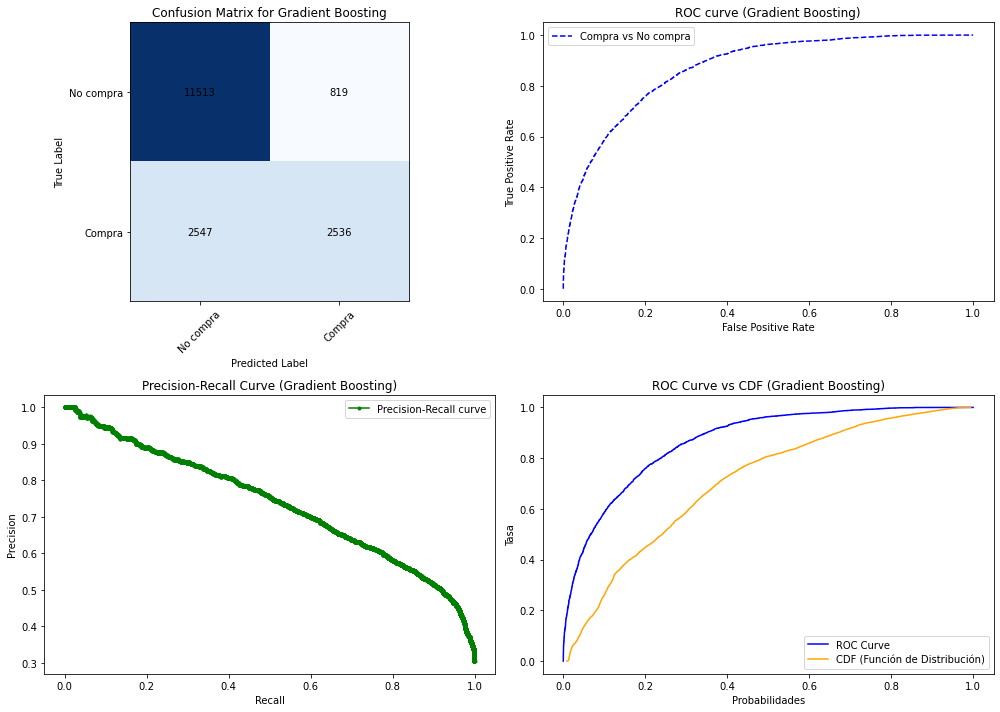

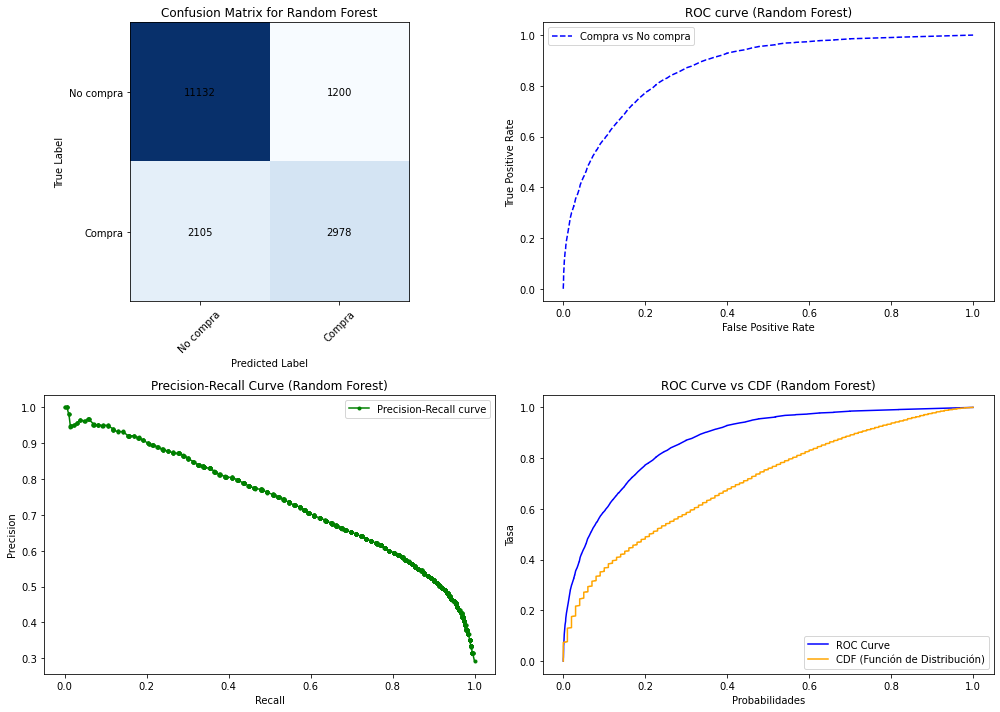

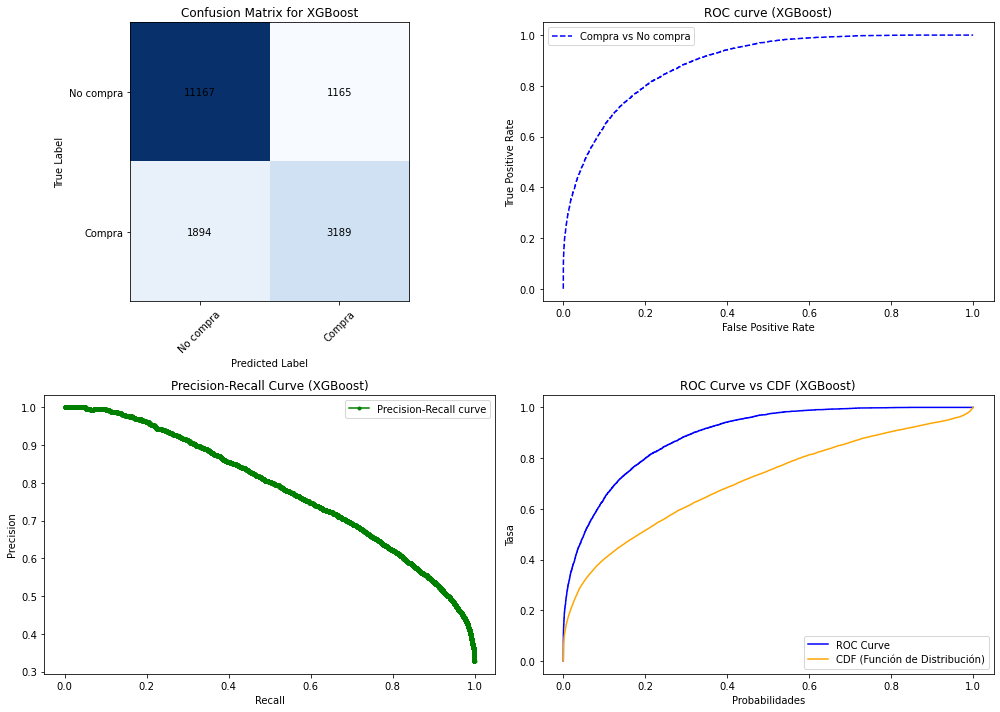

In [24]:
evaluation_GB = Evaluation(GB_model, X_test, y_test)
evaluation_RF = Evaluation(RF_model, X_test, y_test)
evaluation_XGB = Evaluation(XGBClassifier_model, X_test, y_test)

# Graficas de evaluacion.
evaluation_GB.plot('Gradient Boosting')
evaluation_RF.plot('Random Forest')
evaluation_XGB.plot('XGBoost')

El modelo que mejor predice si un cliente comprará más de un coche o no, con base a los resultados obtenidos, parece ser XGBoost. Aunque los otros modelos también tienen un buen rendimiento, XGBoost supera al resto en la mayoría de las métricas clave, lo que lo hace más adecuado para este análisis. 

Guardemos el modelo XGBoost empleando joblib.

In [25]:
# Almacenamos nuestro modelo ya entrenado.
joblib.dump(XGBClassifier_model, 'modelo_XGB.pkl')

['modelo_XGB.pkl']